In [37]:
import pandas as pd

df_dance = pd.read_csv('../data/dataset_0.csv')
df_idle = pd.read_csv('../data/dataset_1.csv')
df_walk = pd.read_csv('../data/dataset_2.csv')
df_run = pd.read_csv('../data/dataset_3.csv')
df_spin = pd.read_csv('../data/dataset_4.csv')

In [38]:
df = pd.concat([df_dance, df_idle, df_walk, df_run, df_spin])
df.rename(columns={'Set': 'Label'}, inplace=True)
df.drop(columns=['OrientationX_sin', 'OrientationX_cos', 'OrientationY_sin', 'OrientationY_cos', 'OrientationZ_sin', 'OrientationZ_cos'], inplace=True) #Let´s try to use only accelerometer and gyroscope at least for now

In [39]:
df.describe()

,AnimIndex,AccelerationX,AccelerationY,AccelerationZ,GyroscopeX,GyroscopeY,GyroscopeZ
count,100885.000000,100885.000000,100885.000000,100885.000000,100885.000000,100885.000000,100885.000000
mean,22.773296,0.512160,0.602361,-13.880446,0.021490,-0.134352,0.027093
std,13.720834,351.392805,80.974049,725.671497,1.952378,3.457387,3.041067
min,0.000000,-12158.802680,-3558.359820,-20438.724145,-69.101625,-137.498576,-157.101248
25%,11.000000,-5.383237,-4.924168,-38.912660,-0.159503,-0.219591,-0.138246
50%,23.000000,0.001952,-0.018100,-0.196599,-0.004404,-0.004562,0.004975
75%,33.000000,5.571368,4.750234,1.819372,0.143643,0.177220,0.158001
max,53.000000,12075.459636,3520.777847,20343.089371,74.797051,125.485251,156.235443


In [40]:
from sklearn.preprocessing import StandardScaler

feature_cols = ['AccelerationX', 'AccelerationY', 'AccelerationZ', 'GyroscopeX', 'GyroscopeY', 'GyroscopeZ']
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [41]:
import numpy as np

def create_sliding_windows(data, label_col, window_size, step_size):
    sequences = []
    labels = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        sequences.append(window[feature_cols].values)
        label = window[label_col].mode()[0]
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 100
step_size = 25
X, y = create_sliding_windows(df, label_col='Label', window_size=window_size, step_size=step_size)

In [42]:
from sklearn.model_selection import train_test_split

train_indices, temp_indices = train_test_split(df['AnimIndex'].unique(), test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

train_data = df[df['AnimIndex'].isin(train_indices)]
val_data = df[df['AnimIndex'].isin(val_indices)]
test_data = df[df['AnimIndex'].isin(test_indices)]

X_train, y_train = create_sliding_windows(train_data, label_col='Label', window_size=window_size, step_size=step_size)
X_val, y_val = create_sliding_windows(val_data, label_col='Label', window_size=window_size, step_size=step_size)
X_test, y_test = create_sliding_windows(test_data, label_col='Label', window_size=window_size, step_size=step_size)

In [43]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [44]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [45]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

model = Sequential([
    LSTM(128, input_shape=(window_size, len(feature_cols)), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100, 128)          69120     
                                                                 
 batch_normalization_4 (Batc  (None, 100, 128)         512       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 100, 128)          0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_11 (Dropout)        (None, 64)               

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)])

Epoch 1/100
52/52 [==============================] - 12s 173ms/step - loss: 2.0023 - accuracy: 0.2184 - val_loss: 1.6233 - val_accuracy: 0.3017 - lr: 1.0000e-04
Epoch 2/100
52/52 [==============================] - 8s 158ms/step - loss: 1.5989 - accuracy: 0.3792 - val_loss: 1.6214 - val_accuracy: 0.2241 - lr: 1.0000e-04
Epoch 3/100
52/52 [==============================] - 8s 152ms/step - loss: 1.3832 - accuracy: 0.4718 - val_loss: 1.6252 - val_accuracy: 0.2299 - lr: 1.0000e-04
Epoch 4/100
52/52 [==============================] - 8s 156ms/step - loss: 1.2397 - accuracy: 0.5404 - val_loss: 1.5876 - val_accuracy: 0.2328 - lr: 1.0000e-04
Epoch 5/100
52/52 [==============================] - 8s 158ms/step - loss: 1.1159 - accuracy: 0.5745 - val_loss: 1.4862 - val_accuracy: 0.2586 - lr: 1.0000e-04
Epoch 6/100
52/52 [==============================] - 8s 154ms/step - loss: 1.0937 - accuracy: 0.5897 - val_loss: 1.3245 - val_accuracy: 0.4425 - lr: 1.0000e-04
Epoch 7/100
52/52 [====================

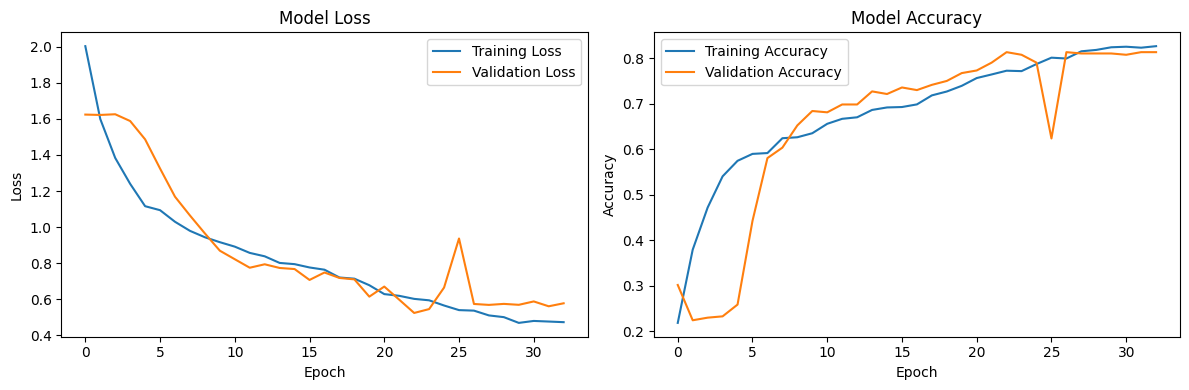

In [47]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

13/13 [==============================] - 0s 36ms/step - loss: 0.5589 - accuracy: 0.7944
Test Loss: 0.5589, Test Accuracy: 0.7944


In [49]:
model.save('../models/imu_rnn_classifier.keras')